# WFDB Beat Detection Example


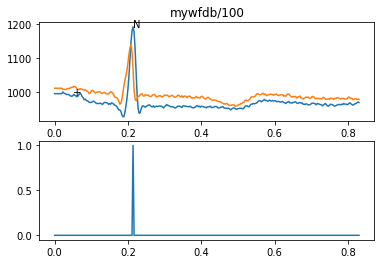

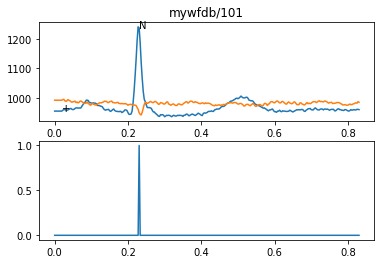

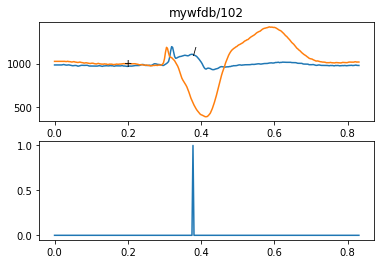

In [1]:
# Beat annotation codes:
# NORMAL   N   Normal beat
# LBBB     L   Left bundle branch block beat
# RBBB     R   Right bundle branch block beat
# BBB      B   Bundle branch block beat (unspecified)
# APC      A   Atrial premature beat
# ABERR    a   Aberrated atrial premature beat
# NPC      J   Nodal (junctional) premature beat
# SVPB     S   Supraventricular premature or ectopic beat (atrial or nodal)
# PVC      V   Premature ventricular contraction
# RONT     r   R-on-T premature ventricular contraction
# FUSION   F   Fusion of ventricular and normal beat
# AESC     e   Atrial escape beat
# NESC     j   Nodal (junctional) escape beat
# SVESC    n   Supraventricular escape beat (atrial or nodal) [1]
# VESC     E   Ventricular escape beat
# PACE     /   Paced beat
# PFUS     f   Fusion of paced and normal beat
# UNKNOWN  Q   Unclassifiable beat
# LEARN    ?   Beat not classified during learning
#
# Any other codes are non-beat annotation codes.

%matplotlib inline
import tensorflow as tf
import numpy as np
import wfdb
import os.path
import matplotlib.pyplot as plt
import random

BEAT_ANNOTATIONS = ('N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q','?')
LOCAL_WFDB_PATH='mywfdb'
WFDB_DB = 'mitdb'

# If the data doesn't exist, download it.
if not os.path.isdir(LOCAL_WFDB_PATH):
    wfdb.io.dl_database(WFDB_DB, LOCAL_WFDB_PATH)

# Load all of the records and resample to 1000 SPS
recordNameList = wfdb.io.get_record_list(WFDB_DB)

plotNum = 1
datasetList = list()
annosetList = list()
Fs = 0

for recordName in recordNameList:
    recordPath = os.path.join(LOCAL_WFDB_PATH, recordName)
    # record_name, n_sig, fs, sig_len
    record = wfdb.rdrecord(recordPath)
    if Fs == 0:
        Fs = record.fs

    # record_name, extension, sample, symbol
    ann = wfdb.rdann(recordPath, 'atr')
    y = np.zeros((record.sig_len, 1))
    t = np.arange(record.sig_len) * 1.0/record.fs
    for k in range(len(ann.sample)):
        if ann.symbol[k] in BEAT_ANNOTATIONS:
            y[ann.sample[k]] = 1.0

    x = record.adc()
    datasetList.append(x)
    annosetList.append(y)
    
    # Plot the first four ECG signals
    if plotNum < 4:
        plt.figure(plotNum)
        plt.subplot(2,1,1)
        plt.plot(t[:300], x[:300,:])
        for i in range(len(ann.sample)):
            if ann.sample[i] < 300:
                idx = ann.sample[i]
                plt.text(t[idx], x[idx,0], ann.symbol[i])
            else:
                break

        plt.title(recordPath)
        plt.subplot(2,1,2)
        plt.plot(t[:300], y[:300])

        plt.show()
    plotNum = plotNum + 1

dataset = np.array(datasetList)
labels = np.array(annosetList)

assert(dataset.shape[0] == labels.shape[0])
assert(dataset.shape[1] == labels.shape[1])

NUM_EXAMPLES = dataset.shape[0]
NUM_TIMESTEPS = dataset.shape[1]
NUM_FEATURES = dataset.shape[2]
NUM_CLASS_LABELS = 2 # Class 1 no-beat, class 2 beat.


For the first experiment, divide the data into a training set and a test set. Since this is a small data set (only 48) recordings, we should use ten-fold cross validation in the final experiment.

In [2]:
NUM_TRAIN = int(NUM_EXAMPLES * 3/4)

# Randomly sample the dataset. Keep 75% for training, 25% for testing.
random.seed(12345)
shuffled_idx = random.sample(tuple(range(NUM_EXAMPLES)), k=NUM_EXAMPLES)

train_x, train_y = dataset[shuffled_idx[:NUM_TRAIN]], labels[shuffled_idx[:NUM_TRAIN]]
test_x, test_y = dataset[shuffled_idx[NUM_TRAIN:]], labels[shuffled_idx[NUM_TRAIN:]]


To train the neural network, the algorithm feeds data into the neural network one window at a time, with a 1/2 window overlap. The window size is one of the hyperparameters that can be tuned for performance.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1840      
_________________________________________________________________
dense_1 (Dense)              (None, 180)               3780      
Total params: 5,620
Trainable params: 5,620
Non-trainable params: 0
_________________________________________________________________
fix x shape (259992, 180, 2)
fix y shape (259992, 180, 1)
Train on 259992 samples
259992/259992 [==============================] - 41s 159us/sample - loss: 0.0242 - accuracy: 0.9964


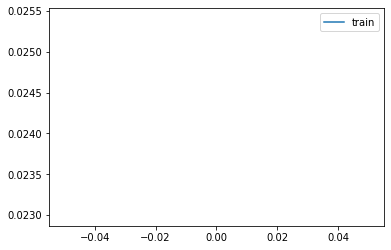

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Re-slice the data with overlapped windows for training in Tensorflow
def window_dataset(x, y, window_size, window_overlap):
    """
    This divides the data, x, and the labels, y, into overlapping windows
    for use in training or testing an LSTM neural network.

    """
    dataX, dataY = [], []
    for example in range(x.shape[0]):
        idx = 0
        while idx < x.shape[1] - window_size:
            slice_x = x[example, idx:idx+window_size]
            slice_y = y[example, idx:idx+window_size]
            dataX.append(slice_x)
            dataY.append(slice_y)
            idx = idx + window_overlap

        # slice off the remaining window, with zero padding
        pad_width = window_size - (x.shape[1] - idx)
        if pad_width > 0:
            paddedX = np.pad(x[example, idx:], ((0,pad_width), (0,0)), mode='edge')
            paddedY = np.pad(y[example, idx:], ((0,pad_width), (0,0)), mode='edge')

            dataX.append( paddedX )
            dataY.append( paddedY )

    return np.array(dataX), np.array(dataY)    

WINDOW_SIZE = int(Fs/2)
WINDOW_OVERLAP = int(WINDOW_SIZE/2)

nn_input_shape=(WINDOW_SIZE, NUM_FEATURES)
INTERNAL_UNITS = 20

# ------ Configure the Network -----
model = Sequential()
model.add(LSTM(INTERNAL_UNITS, input_shape=nn_input_shape, return_sequences=False))
model.add(Dense(nn_input_shape[0], input_shape=(nn_input_shape[0], INTERNAL_UNITS), activation='softmax'))
model.summary()

model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS=1
BATCH_SIZE=64
fit_x, fit_y = window_dataset(train_x, train_y, WINDOW_SIZE, WINDOW_OVERLAP)
print("fix x shape", fit_x.shape)
print("fix y shape", fit_y.shape)
history = model.fit(fit_x, fit_y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()


In [10]:
windowed_test_x, windowed_test_y = window_dataset(test_x, test_y, WINDOW_SIZE, WINDOW_OVERLAP)

# Run against the test set. Final evaluation of the model
scores = model.evaluate(windowed_test_x, windowed_test_y, batch_size=BATCH_SIZE, verbose=2)
print("Test set analysis accuracy: %.2f%%" % (scores[1]*100))

print("eval x shape", windowed_test_x.shape)
print("eval y shape", windowed_test_y.shape)


86664/1 - 6s - loss: 0.0211 - accuracy: 0.9968
Test set analysis accuracy: 99.68%
eval x shape (86664, 180, 2)
eval y shape (86664, 180, 1)


In [11]:
# Generate the predictions for the entire test dataset.
predictions = model.predict(windowed_test_x, batch_size=BATCH_SIZE)
print('predictions shape:', predictions.shape)

plt.subplot(2,1,1)
plt.plot(t[:600], windowed_test_x[0])
plt.subplot(2,1,2)
#plt.plot(t[:600], test_y[:600,:])


TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type int64 of argument 'a'.